In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # matplotlib is for drawing graphs
import matplotlib.colors as colors
from sklearn.utils import resample # downsample the dataset
from sklearn.model_selection import train_test_split # split data into training and testing sets
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC # this will make a support vector machine for classificaiton
from sklearn.model_selection import GridSearchCV #this will do cross validation
from sklearn.metrics import confusion_matrix # this creates a confusion matrix
from sklearn.decomposition import PCA # to perform PCA to plot the data
from sklearn.metrics import precision_score, accuracy_score, recall_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

In [2]:
df = pd.read_csv("default of credit card clients.txt",sep='\t',header=1)
df.drop('ID',axis=1,inplace=True)
df.rename(columns={'default payment next month': 'DEFAULT'}, inplace=True)
df_no_missing = df.loc[(df['MARRIAGE']!=0) & (df['EDUCATION']!=0)]
df_no_missing.head()
df_no_default = df_no_missing[df_no_missing['DEFAULT']==0]
df_default = df_no_missing[df_no_missing['DEFAULT']==1]
df_no_default_downsampled = resample(df_no_default,replace=False,n_samples=1000,random_state=42)
df_default_downsampled = resample(df_default,replace=False,n_samples=1000,random_state=42)
df_downsampled = pd.concat([df_no_default_downsampled,df_default_downsampled])
X = df_downsampled.drop(['DEFAULT'],axis=1).copy()
y = df_downsampled['DEFAULT'].copy()
X_encoded = pd.get_dummies(X,columns=['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']).astype(int)
X_train,X_test,y_train,y_test = train_test_split(X_encoded,y,random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)
print("pre-proccessing");

pre-proccessing


Number of columns: 81


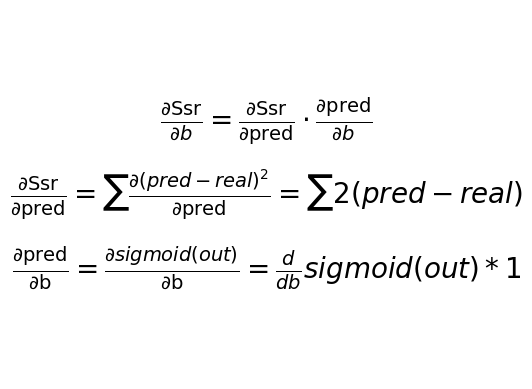

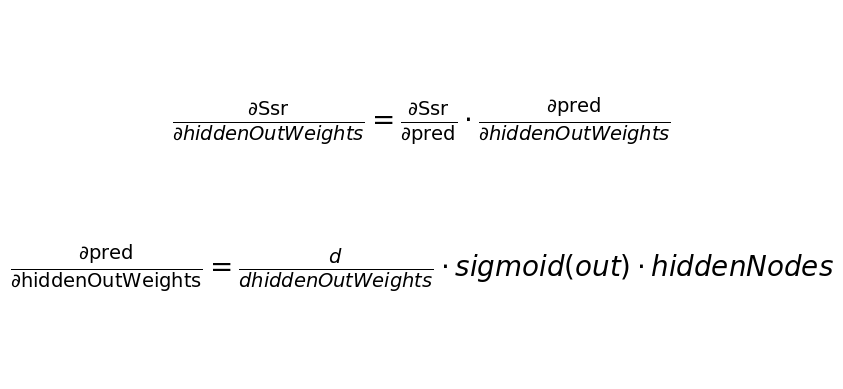

In [25]:
print(f"Number of columns: {X_train_scaled.shape[1]}")
input_nodes_num = X_train_scaled.shape[1]
hidden_nodes_num = 8
output_nodes_num = 1
np.random.seed(42)


equation1 = r'$\frac{\partial \text{Ssr}}{\partial b} = \frac{\partial \text{Ssr}}{\partial \text{pred}} \cdot \frac{\partial \text{pred}}{\partial b}$'
equation2 = r'$\frac{\partial \text{Ssr}}{\partial \text{pred}} = \sum\frac{\partial (pred - real)^{2}}{\partial \text{pred}} = \sum2(pred - real)$'
equation3 = r'$\frac{\partial \text{pred}}{\partial \text{b}} = \frac{\partial sigmoid(out)}{\partial \text{b}} = \frac{d}{db}sigmoid(out)*1$'    
plotEquations(equation1,equation2,equation3,"Hidden Layer weight's backpropagation")
equation1 = r'$\frac{\partial \text{Ssr}}{\partial hiddenOutWeights} = \frac{\partial \text{Ssr}}{\partial \text{pred}} \cdot \frac{\partial \text{pred}}{\partial hiddenOutWeights}$' 
equation2 = ''
equation3 = r'$\frac{\partial \text{pred}}{\partial \text{hiddenOutWeights}} =  \frac{d}{dhiddenOutWeights} \cdot sigmoid(out)\cdot hiddenNodes$'    
plotEquations(equation1,equation2,equation3,"Output Layer bias backpropagation")


In [9]:
learning_rate = 0.0001
#hidden-input layer wieghts and biases
input_hidden_weights = np.random.rand(input_nodes_num,hidden_nodes_num)
input_hidden_baises = np.zeros(hidden_nodes_num)

#hidden-output layer wieghts and biases
hidden_out_weights = np.random.rand(hidden_nodes_num,output_nodes_num)
hidden_out_baises = 0
# print(f"hidden_out_baises : {hidden_out_baises}" )
# print(f"hidden_out_weights : {hidden_out_weights}" )
# print(f"input_hidden_weights : {input_hidden_weights}" )
# print(f"input_hidden_baises : {input_hidden_baises}" )X_train_scaled[i]
for epoch in range(100):
    i =0
    predicated_values = []
    hidden_layer =[]
    outputs_values =[]
    for i in range(0,len(X_train_scaled)):
        input_nodes = X_train_scaled[i]
        pred,hidden_nodes,output_node = forward(input_nodes,input_hidden_weights,hidden_out_weights,input_hidden_baises,hidden_out_baises)
        real = y_train.iloc[i]
        outputs_values.append(output_node)
        predicated_values.append(pred)
        hidden_layer.append(hidden_nodes)
    # mydf = pd.DataFrame({
    #     'outputs': outputs_values,
    #     'real': y_train,
    #     'predicated': predicated_values
    # })
    # #print(mydf)

    
    outputs_values = np.array(outputs_values).flatten()
    predicated_values = np.array(predicated_values).flatten()
    hidden_layer = np.array(hidden_layer)
    observed_values =  y_train.to_numpy()

    ssr = np.sum((observed_values-predicated_values)**2)
    loss = binary_cross_entropy(y_train.to_numpy(), outputs_values)
    #print("Initial Loss:", loss)
    
     # Compute gradients for output layer
    dSSR_dpred = predicated_values - observed_values  # Gradient of loss with respect to predictions
    sigmoid_derivs = sigmoid_derivative(outputs_values)  # Derivative of sigmoid output
    
    d_output_weights = np.dot(hidden_layer.T, (dSSR_dpred * sigmoid_derivs).reshape(-1, 1))
    d_output_biases = np.sum(dSSR_dpred * sigmoid_derivs, axis=0)
    
    # Compute gradients for hidden layer
    d_hidden_error = (dSSR_dpred * sigmoid_derivs).reshape(-1, 1) @ hidden_out_weights.T * hidden_layer>0
    
    d_hidden_weights = np.dot(X_train_scaled.T, d_hidden_error)
    d_hidden_biases = np.sum(d_hidden_error, axis=0)
    
    # Update weights and biases
    input_hidden_weights -= learning_rate * d_hidden_weights
    input_hidden_baises -= learning_rate * d_hidden_biases
    
    hidden_out_weights -= learning_rate * d_output_weights
    hidden_out_baises -= learning_rate * d_output_biases

print(f"hidden_out_baises : {hidden_out_baises}" )
print(f"hidden_out_weights : {hidden_out_weights}" )
print(f"input_hidden_weights : {input_hidden_weights}" )
print(f"input_hidden_baises : {input_hidden_baises}" )

hidden_out_baises : -0.14750387808923426
hidden_out_weights : [[0.77107333]
 [0.48090278]
 [0.06433812]
 [0.52114834]
 [0.56887561]
 [0.72741427]
 [0.42979966]
 [0.13006066]]
input_hidden_weights : [[-7.53323057e-02  2.38738789e-01  1.57639071e-01  6.67109028e-04
  -2.59869611e-01 -1.49318549e-01 -3.43885315e-01  2.49698251e-01]
 [ 2.36077890e-01  4.46100369e-01 -7.17992268e-02  5.28809019e-01
   4.60008148e-01  6.52149988e-02 -4.37846498e-02  2.32256076e-02]
 [ 5.45844314e-02 -2.80021980e-02  5.85537946e-02 -1.78644967e-01
   1.45610094e-01 -8.88923715e-02 -1.04399407e-01  4.53538263e-03]
 [ 1.80038132e-01  1.92043700e-01 -1.86408814e-01 -5.69091698e-02
   1.15133823e-01 -2.84014076e-01  1.37523535e-01 -2.15663124e-01]
 [-1.74779163e-01  2.86338101e-01  4.49489512e-01  1.10487225e-01
  -2.34088117e-01 -2.55425957e-01  1.87546678e-01 -3.67988082e-03]
 [-1.95203916e-01 -9.58226336e-02 -4.59423642e-01  2.74703044e-01
  -2.62800445e-01  2.69659711e-01 -2.19242842e-01 -2.26521585e-02]
 [ 1

In [33]:
def forward(input_nodes1,input_hidden_weights1,hidden_out_weights1,input_hidden_baises1,hidden_out_baises1):
    #initialize hidden nodes
    hidden_nodes1 = np.dot(input_nodes1,input_hidden_weights1)
    hidden_nodes1 = np.add(hidden_nodes1,input_hidden_baises1)
    hidden_nodes1 = relu(hidden_nodes1)
    #initialize out node
    output_node1 = np.dot(hidden_nodes1,hidden_out_weights1)
    output_node1 = np.add(output_node1,hidden_out_baises1)
    predictions1 = sigmoid(output_node1)
    return predictions1,hidden_nodes1,output_node1
def plotEquations(q1,q2,q3,title):
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots()

    ax.axis('off')
    
    ax.text(0.5, 0.7, q1, fontsize=20, ha='center', va='center')
    
    ax.text(0.5, 0.5, q2, fontsize=20, ha='center', va='center')
    
    ax.text(0.5, 0.3, q3, fontsize=20, ha='center', va='center')
    
    plt.savefig('images/'+title+'.png', bbox_inches='tight', pad_inches=0.1, dpi=300)
    plt.show()
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def relu(x):
    return np.maximum(0, x) 
def sigmoid_derivative(x):
    sigmoid_x = sigmoid(x)
    return sigmoid_x * (1 - sigmoid_x)
def tanh(x):
    return np.tanh(x)
def tanh_derivative(x):
    return 1 - np.tanh(x)**2    
def binary_cross_entropy(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))    

def plot_confusion_mat(predictions,y_test1,title):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'magma')
    plt.savefig('images/'+title+'.png')
    plt.show()
    # Calculate precision, accuracy, and sensitivity
    precision = precision_score(y_test1, predictions)
    accuracy = accuracy_score(y_test1, predictions)
    sensitivity = recall_score(y_test1, predictions)

    print(f'Precision: {precision:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Sensitivity (Recall): {sensitivity:.4f}')    

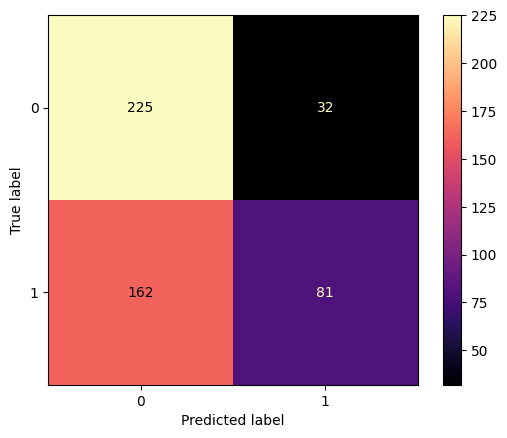

Precision: 0.7168
Accuracy: 0.6120
Sensitivity (Recall): 0.3333


In [34]:
predictions = []
for i in range(0,len(X_test_scaled)):
    input_nodes = X_test_scaled[i]
    pred,_,_ = forward(input_nodes,input_hidden_weights,hidden_out_weights,input_hidden_baises,hidden_out_baises)
    predictions.append(pred)
my_model_predictions = (np.array(predictions)>= 0.5).astype(int)
    
plot_confusion_mat(my_model_predictions,y_test,"My model confusion matrix");

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [13]:
def build_model(units=8, optimizer='adam',learning_rate=0.01):
    model = Sequential()
    input_shape = X_train_scaled.shape[1]
    model.add(Input(shape=(input_shape,)))
    model.add(Dense(units, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2,verbose=0)
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adagrad':
        opt = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
    elif optimizer == 'adadelta':
        opt = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == 'nadam':
        opt = tf.keras.optimizers.Nadam(learning_rate=learning_rate)
    elif optimizer == 'ftrl':
        opt = tf.keras.optimizers.Ftrl(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
        
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [14]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV 
model = KerasClassifier(model=build_model,epochs=100,batch_size=32, verbose=0)

param_grid = {
    'model__units': [8],
    'model__optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad'],
    #'optimizer': ['adam', 'sgd', 'rmsprop', 'adagrad', 'adadelta', 'nadam', 'ftrl'],
    'model__learning_rate': [0.01, 0.001, 0.0001],
    #'batch_size': [32, 64],
    #'epochs': [50, 100]
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5,verbose=5)

grid_result = grid.fit(X_train_scaled, y_train)

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best: 0.6966666666666667 using {'model__learning_rate': 0.0001, 'model__optimizer': 'adam', 'model__units': 8}


In [15]:
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, std, param in zip(means, stds, params):
    print(f"Mean accuracy: {mean:.4f} (std: {std:.4f}) with: {param}")

Mean accuracy: 0.6493 (std: 0.0112) with: {'model__learning_rate': 0.01, 'model__optimizer': 'adam', 'model__units': 8}
Mean accuracy: 0.6880 (std: 0.0225) with: {'model__learning_rate': 0.01, 'model__optimizer': 'sgd', 'model__units': 8}
Mean accuracy: 0.6800 (std: 0.0196) with: {'model__learning_rate': 0.01, 'model__optimizer': 'rmsprop', 'model__units': 8}
Mean accuracy: 0.6853 (std: 0.0278) with: {'model__learning_rate': 0.01, 'model__optimizer': 'adagrad', 'model__units': 8}
Mean accuracy: 0.6700 (std: 0.0243) with: {'model__learning_rate': 0.001, 'model__optimizer': 'adam', 'model__units': 8}
Mean accuracy: 0.6493 (std: 0.0172) with: {'model__learning_rate': 0.001, 'model__optimizer': 'sgd', 'model__units': 8}
Mean accuracy: 0.6860 (std: 0.0140) with: {'model__learning_rate': 0.001, 'model__optimizer': 'rmsprop', 'model__units': 8}
Mean accuracy: 0.6540 (std: 0.0252) with: {'model__learning_rate': 0.001, 'model__optimizer': 'adagrad', 'model__units': 8}
Mean accuracy: 0.6967 (std

In [36]:
model = build_model(units=8, optimizer='adam',learning_rate=0.0001)
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_split=0.2,verbose=0)
predictions1 = model.predict(X_test_scaled)
tensor_predictions = (np.array(predictions1)>= 0.5).astype(int)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


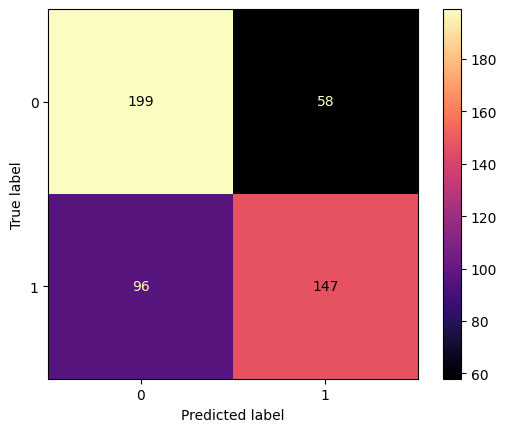

Precision: 0.7171
Accuracy: 0.6920
Sensitivity (Recall): 0.6049


In [38]:
plot_confusion_mat(tensor_predictions,y_test,"Tensor flow model confusion matrix")   

In [39]:
weights_and_biases = model.get_weights()

# Separate weights and biases for better understanding
weights = weights_and_biases[::2]  # Even indices are weights
biases = weights_and_biases[1::2]  # Odd indices are biases

# Print weights and biases for each layer
for i, (w, b) in enumerate(zip(weights, biases)):
    print(f"Layer {i+1} weights shape: {w.shape}")
    print(f"Layer {i+1} weights: {w}")
    print(f"Layer {i+1} biases shape: {b.shape}")
    print(f"Layer {i+1} biases: {b}")

Layer 1 weights shape: (81, 8)
Layer 1 weights: [[ 1.34811193e-01 -1.12060020e-02 -1.61645353e-01 -3.13299745e-01
   2.30541565e-02  2.31209934e-01 -2.55183309e-01  2.36904517e-01]
 [-5.97466715e-02 -2.21354321e-01 -1.92115784e-01  3.95700186e-02
  -1.86483160e-01 -1.87749490e-01 -6.26029968e-02  1.72360763e-01]
 [ 2.78430015e-01  1.64078355e-01  2.73930401e-01 -1.20893322e-01
   3.42133716e-02  1.01107515e-01 -2.20266089e-01  7.62365535e-02]
 [-1.58680454e-01 -1.02677144e-01 -8.67588911e-03  5.62391058e-02
   7.26309046e-02 -4.18067202e-02  2.03677788e-01 -2.02449873e-01]
 [-5.47942743e-02 -1.61095262e-01 -1.24167681e-01 -5.05404063e-02
  -1.30238965e-01 -1.57431930e-01  1.19022623e-01 -1.45420730e-01]
 [ 1.01731233e-01  1.77127019e-01  1.61923110e-01  1.48730293e-01
  -1.97064996e-01  2.94910282e-01  8.57324675e-02 -1.87447872e-02]
 [-1.65323898e-01  7.85908699e-02 -2.07940117e-01 -1.85976624e-02
   2.91996002e-01  9.64923482e-03 -3.27058077e-01  6.63817674e-02]
 [-5.28792478e-02  1.

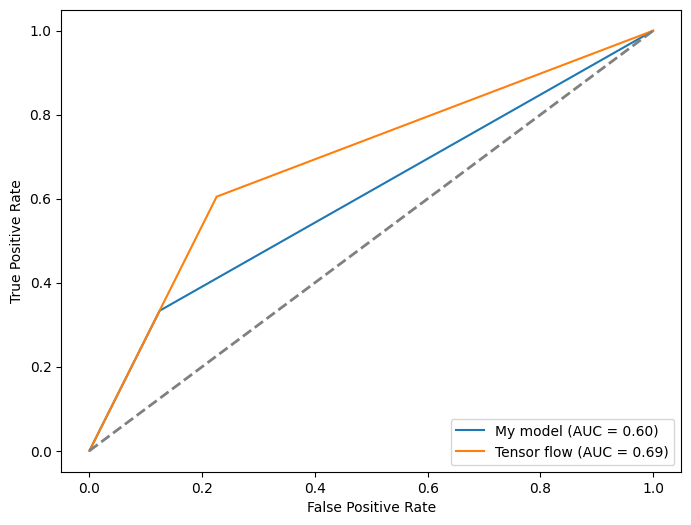

In [42]:
fpr_my_model, tpr_my_model, thresholds_my_model = roc_curve(y_test, my_model_predictions)
roc_auc_my_model = auc(fpr_my_model, tpr_my_model)

fpr_tensor_model, tpr_tensor_model, thresholds_tensor_model = roc_curve(y_test, tensor_predictions)
roc_auc_tensor_model = auc(fpr_tensor_model, tpr_tensor_model)

plt.figure(figsize=(8, 6))

plt.plot(fpr_my_model, tpr_my_model, label=f'My model (AUC = {roc_auc_my_model:.2f})')
plt.plot(fpr_tensor_model, tpr_tensor_model, label=f'Tensor flow (AUC = {roc_auc_tensor_model:.2f})')

# Plot a diagonal line for reference
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right')
plt.savefig('images/Roc-auc.png')
# Show the plot
plt.show()